# Paris Saclay Center for Data Science : prédiction du nombre de passagers aériens


---
## Introduction


---

L'ensemble de données nous a été donné par une société anonyme qui s'occupe de la réservation des billets d'avion. Les données sont "maigres", mais elles contiennent : 

- la date de départ
- l'aéroport de départ
- l'aéroport d'arrivée
- la moyenne et l'écart-type du nombre de semaines des réservations effectuées avant la date de départ
- un champ appelé `log_PAX` qui est lié au nombre de passagers (le nombre réel a été modifié pour des raisons de confidentialité)

L'objectif est de prédire la colonne `log_PAX`. La qualité de la prédiction est mesurée par RMSE.

Les données sont évidemment limitées, mais comme les données et les informations de localisation sont disponibles, elles peuvent être jointes à des données externes. Le défi de ce RAMP est de trouver de bonnes données qui peuvent être corrélées au trafic aérien.

In [2]:
import os
from distance_calcul import distance
from scipy.stats import mode
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from describe import stats_histo
import problem
import warnings
from visualisation import plot_coeff_importances, plot_stages
import shap

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

```
import sys, importlib
importlib.reload(sys.modules['visualisation'])
```

---
## Chargement des données
---

Les données relatives à la formation et aux tests se trouvent dans le dossier `data`. Elles sont compressées dans un fichier `csv` (c'est-à-dire `csv.bz2`). Nous pouvons charger l'ensemble de données en utilisant des pandas.

In [3]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [4]:
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


La colonne `log_PAX` est la cible de notre problème de régression. Les autres colonnes sont les caractéristiques qui seront utilisées pour la prédiction.

`Departure` et `Arrival` sont le code de l'aéroport. Toutefois, nous voyons que la `DateOfDeparture` devrait être une date au lieu d'une chaîne de caractères. Nous pouvons utiliser des pandas pour convertir ces données.

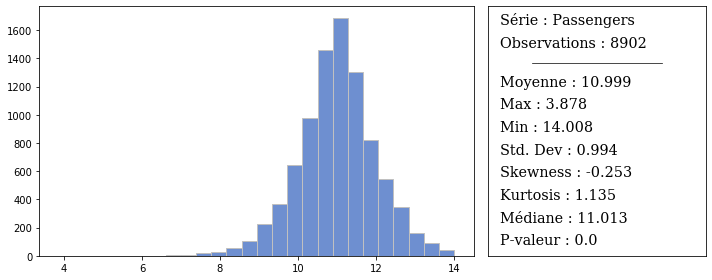

In [5]:
stats_histo(y_train, 'Passengers')

---
## Préprocessing
---

Nous effectuerons toutes les étapes de prétraitement dans le cadre d'une `pipeline` scikit-learn qui enchaîne les étapes de transformation et d'estimation. 

Cette méthode est pratique et sûre (elle permet d'éviter les fuites de statistiques de vos données de test dans le modèle formé lors de la validation croisée). De plus, l'ensemble du pipeline peut être évalué avec `cross_val_score`.

Pour effectuer le codage ci-dessus dans un pipeline scikit-learn, nous allons créer une fonction et utiliser `FunctionTransformer` pour la rendre compatible avec l'API scikit-learn.

### Transformeurs : préprocessing des dates

Un dictionnaire qu'on va utiliser :
```python
external_dico['PHL']['lat']
```

In [6]:
external_dico = {'PHL': {'lat': 39.87195, 'long': -75.24114, 
                         'state': 'Pennsylvania', 'altitude': 36, 
                         'tz': 'New_York', 'pop_2011': 5543}, 'DFW': 
                 {'lat': 32.89595, 'long': -97.0372, 'state': 'Texas', 'altitude': 607, 'tz': 'Chicago', 'pop_2011': 15567}, 'IAH': {'lat': 29.98047, 'long': -95.33972, 'state': 'Texas', 'altitude': 97, 'tz': 'Chicago', 'pop_2011': 15567}, 'ATL': {'lat': 33.640440000000005, 'long': -84.42694, 'state': 'Georgia', 'altitude': 1026, 'tz': 'New_York', 'pop_2011': 8082}, 'BOS': {'lat': 42.36435, 'long': -71.00518000000001, 'state': 'Massachusetts', 'altitude': 20, 'tz': 'New_York', 'pop_2011': 63593}, 'LAX': {'lat': 33.94254, 'long': -118.40807, 'state': 'California', 'altitude': 125, 'tz': 'Los_Angeles', 'pop_2011': 64980}, 'SFO': {'lat': 37.619, 'long': -122.37483999999999, 'state': 'California', 'altitude': 13, 'tz': 'Los_Angeles', 'pop_2011': 64980}, 'EWR': {'lat': 40.6925, 'long': -74.16866, 'state': 'New Jersey', 'altitude': 18, 'tz': 'New_York', 'pop_2011': 12957}, 'JFK': {'lat': 40.63975, 'long': -73.77893, 'state': 'New York', 'altitude': 13, 'tz': 'New_York', 'pop_2011': 20688}, 'LGA': {'lat': 40.77724, 'long': -73.87261, 'state': 'New York', 'altitude': 21, 'tz': 'New_York', 'pop_2011': 20688}, 'DTW': {'lat': 42.21206, 'long': -83.34884, 'state': 'Michigan', 'altitude': 645, 'tz': 'New_York', 'pop_2011': 9535}, 'DEN': {'lat': 39.85841, 'long': -104.667, 'state': 'Colorado', 'altitude': 5431, 'tz': 'Denver', 'pop_2011': 13884}, 'CLT': {'lat': 35.214009999999995, 'long': -80.94313000000001, 'state': 'North Carolina', 'altitude': 748, 'tz': 'New_York', 'pop_2011': 9728}, 'MSP': {'lat': 44.88055, 'long': -93.21692, 'state': 'Minnesota', 'altitude': 841, 'tz': 'Chicago', 'pop_2011': 5150}, 'SEA': {'lat': 47.44898, 'long': -122.30931000000001, 'state': 'Washington', 'altitude': 433, 'tz': 'Los_Angeles', 'pop_2011': 15777}, 'ORD': {'lat': 41.9796, 'long': -87.90446, 'state': 'Illinois', 'altitude': 672, 'tz': 'Chicago', 'pop_2011': 8610}, 'MCO': {'lat': 28.428890000000003, 'long': -81.31603, 'state': 'Florida', 'altitude': 96, 'tz': 'New_York', 'pop_2011': 23446}, 'MIA': {'lat': 25.79325, 'long': -80.29056, 'state': 'Florida', 'altitude': 8, 'tz': 'New_York', 'pop_2011': 23446}, 'LAS': {'lat': 36.08036, 'long': -115.15233, 'state': 'Nevada', 'altitude': 2181, 'tz': 'Los_Angeles', 'pop_2011': 81044}, 'PHX': {'lat': 33.43417, 'long': -112.00806000000001, 'state': 'Arizona', 'altitude': 1135, 'tz': 'Phoenix', 'pop_2011': 56061}}


La mise en colonnes numériques des dates est une opération courante lorsque les données des séries chronologiques sont analysées à l'aide de prédicteurs non paramétriques. Le code ci-dessous permet d'effectuer les transformations suivantes :

- colonnes numériques pour l'année (2011-2012) 
- le mois (1-12) 
- le jour du mois (1-31),
- la semaine de l'année (1-52)

In [7]:
def parse_date(x):
    date = pd.to_datetime(x, format="%Y-%m-%d")
    return pd.Series([date.year, date.month, date.weekday(), date.week])

In [8]:
from sklearn.preprocessing import FunctionTransformer

def _encoder_dates(X):
    X[["year","month","weekday","week"]] = X[
    "DateOfDeparture"].apply(parse_date)
    X["isweekend"] = X["weekday"] >= 5
    X["isweekend"] = X["isweekend"].astype(int)
    
    return X

date_encoder = FunctionTransformer(_encoder_dates)

In [9]:
date_encoder.fit_transform(X_train).head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,weekday,week,isweekend
0,2012-06-19,ORD,DFW,12.875000,9.812647,2012,6,1,25,0
1,2012-09-10,LAS,DEN,14.285714,9.466734,2012,9,0,37,0
2,2012-10-05,DEN,LAX,10.863636,9.035883,2012,10,4,40,0
3,2011-10-09,ATL,ORD,11.480000,7.990202,2011,10,6,40,1
4,2012-02-21,DEN,SFO,11.450000,9.517159,2012,2,1,8,0


### Transformeur : calcul des distances

In [10]:
def compute_dist(X):   
    X["Distance"] = X.apply(lambda x : 
                            distance((external_dico[x["Departure"]]['lat'],
                                      external_dico[x["Departure"]]['long']),
                                     (external_dico[x["Arrival"]]['lat'], 
                                      external_dico[x["Arrival"]]['long'])), axis=1)
    return X

dist_ = FunctionTransformer(compute_dist)

In [11]:
dist_.fit_transform(X_train).head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,weekday,week,isweekend,Distance
0,2012-06-19,ORD,DFW,12.875000,9.812647,2012,6,1,25,0,1290.779961
1,2012-09-10,LAS,DEN,14.285714,9.466734,2012,9,0,37,0,1009.721628
2,2012-10-05,DEN,LAX,10.863636,9.035883,2012,10,4,40,0,1385.461051
3,2011-10-09,ATL,ORD,11.480000,7.990202,2011,10,6,40,1,976.057905
4,2012-02-21,DEN,SFO,11.450000,9.517159,2012,2,1,8,0,1553.249207


In [12]:
def merge_population (X):   
    X["population_Arrival"] = X.apply(lambda x : 
                       external_dico[x["Arrival"]]['pop_2011'], axis=1)
    
    X["population_departure"] = X.apply(lambda x : 
                       external_dico[x["Departure"]]['pop_2011'], axis=1)                
    return X

popu = FunctionTransformer(merge_population)

In [13]:
popu.fit_transform(X_train).head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,weekday,week,isweekend,Distance,population_Arrival,population_departure
0,2012-06-19,ORD,DFW,12.875000,9.812647,2012,6,1,25,0,1290.779961,15567,8610
1,2012-09-10,LAS,DEN,14.285714,9.466734,2012,9,0,37,0,1009.721628,13884,81044
2,2012-10-05,DEN,LAX,10.863636,9.035883,2012,10,4,40,0,1385.461051,64980,13884
3,2011-10-09,ATL,ORD,11.480000,7.990202,2011,10,6,40,1,976.057905,8610,8082
4,2012-02-21,DEN,SFO,11.450000,9.517159,2012,2,1,8,0,1553.249207,64980,13884


### Transformeur : utiliser les données externes

L'objectif de ce défi de données RAMP est de trouver de bonnes données qui peuvent être corrélées au trafic aérien. Nous utiliserons quelques données externes (enregistrées dans `submissions/submit`).

Nous allons d'abord définir une fonction qui fusionne les données externes à nos données de caractéristiques.

In [14]:
__file__ = os.path.join('submissions', 'submit', 'estimator.py')
filepath = os.path.join(os.path.dirname(__file__), 'external_data.csv')

In [15]:
pd.read_csv(filepath, index_col=0).head(2)

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,CloudCover,Events,WindDirDegrees,Holiday,TOTAL_DEPARTURE,TOTAL_DESTINATION
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,3,Sun,129,0,3582088,3580851
1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,2,Sun,185,0,3582088,3580851


In [16]:
def _merge_external_data(X):
    __file__ = os.path.join('submissions', 'submit', 'estimator.py')
    filepath = os.path.join(os.path.dirname(__file__), 
                            'external_data.csv')
    
    # Importation des données 
    
    X["DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    X_external = pd.read_csv(filepath, parse_dates=["Date"], index_col=0)
    
    
    # Merge sur les départs de vols
    
    X_Departure = X_external.drop(columns="TOTAL_DESTINATION")
    X_merged_Departure = pd.merge(X, X_Departure, 
                        how='left', 
                        left_on=['DateOfDeparture', 'Departure'],
                        right_on = ["Date","AirPort"])
    X_merged_Departure.drop(columns=["Date","AirPort"], inplace=True)
    
    
    # Merge sur les arrivées de vols 
    
    features = list(X_external.columns)
    del features[-2]
    
    X_Arrival = X_external[features]
    X_merged_Arrival = pd.merge(X, X_Arrival, 
                        how='left', 
                        left_on=['DateOfDeparture', 'Arrival'],
                        right_on = ["Date","AirPort"])

    X_merged_Arrival.drop(columns=["Date","AirPort"], inplace=True)
    
    
    # Merge des deux 
    join = list(X_merged_Arrival.columns)[:13]
    X_out = pd.merge(X_merged_Departure, X_merged_Arrival, 
                     how='left', on=join, suffixes=("_depart",'_arrive'))
    
    X_out.drop(columns=["Holiday_arrive"], inplace=True)
    X_out.rename(columns={"Holiday_depart":'Holiday'}, inplace=True)    
    return X_out

data_merger = FunctionTransformer(_merge_external_data)

In [17]:
data_merger.fit_transform(X_train).head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,weekday,week,isweekend,Distance,population_Arrival,population_departure,Max TemperatureC_depart,Mean TemperatureC_depart,Min TemperatureC_depart,Dew PointC_depart,MeanDew PointC_depart,Min DewpointC_depart,Max Humidity_depart,Mean Humidity_depart,Min Humidity_depart,Max Sea Level PressurehPa_depart,Mean Sea Level PressurehPa_depart,Min Sea Level PressurehPa_depart,Max VisibilityKm_depart,Mean VisibilityKm_depart,Min VisibilitykM_depart,Max Wind SpeedKm/h_depart,Mean Wind SpeedKm/h_depart,Max Gust SpeedKm/h_depart,CloudCover_depart,Events_depart,WindDirDegrees_depart,Holiday,TOTAL_DEPARTURE,Max TemperatureC_arrive,Mean TemperatureC_arrive,Min TemperatureC_arrive,Dew PointC_arrive,MeanDew PointC_arrive,Min DewpointC_arrive,Max Humidity_arrive,Mean Humidity_arrive,Min Humidity_arrive,Max Sea Level PressurehPa_arrive,Mean Sea Level PressurehPa_arrive,Min Sea Level PressurehPa_arrive,Max VisibilityKm_arrive,Mean VisibilityKm_arrive,Min VisibilitykM_arrive,Max Wind SpeedKm/h_arrive,Mean Wind SpeedKm/h_arrive,Max Gust SpeedKm/h_arrive,CloudCover_arrive,Events_arrive,WindDirDegrees_arrive,TOTAL_DESTINATION
0,2012-06-19,ORD,DFW,12.875000,9.812647,2012,6,1,25,0,1290.779961,15567,8610,35,31,26,20,18,17,62,51,39,1014,1012,1009,16,16,16,37,25,56.0,1,Sun,208,0,2990847,34,29,24,22,21,19,82,63,44,1012,1010,1009,16,16,16,48,29,60.0,5,Cloud,161,2505886
1,2012-09-10,LAS,DEN,14.285714,9.466734,2012,9,0,37,0,1009.721628,13884,81044,36,32,27,16,13,10,51,36,21,1011,1009,1005,16,15,11,32,18,50.0,5,Cloud,187,0,1620153,33,25,16,-2,-6,-8,21,14,7,1011,1008,1005,16,16,16,35,15,42.0,3,Sun,207,2120025
2,2012-10-05,DEN,LAX,10.863636,9.035883,2012,10,4,40,0,1385.461051,64980,13884,6,2,-1,0,-2,-4,92,76,60,1027,1023,1020,16,9,1,27,15,32.0,7,Snow,357,0,2197864,22,19,16,17,16,14,93,77,61,1018,1016,1014,16,13,8,24,8,29.0,5,Fog,266,2552854
3,2011-10-09,ATL,ORD,11.480000,7.990202,2011,10,6,40,1,976.057905,8610,8082,22,19,16,12,10,6,67,56,44,1026,1024,1021,16,16,16,37,26,45.0,8,Cloud,70,0,3857493,27,19,11,12,10,9,83,58,33,1028,1026,1024,16,16,16,23,6,29.0,1,Sun,93,2842545
4,2012-02-21,DEN,SFO,11.450000,9.517159,2012,2,1,8,0,1553.249207,64980,13884,8,2,-4,-6,-9,-13,46,39,31,1012,1008,1004,16,16,16,61,30,77.0,5,Cloud,270,0,1817722,16,12,8,10,8,7,93,79,64,1027,1025,1024,16,12,3,24,8,29.0,7,Cloud,300,1451351


### Transformeur : encodage one hot – ordinal

In [19]:
def get_dummy(X):
    X = X.join(pd.get_dummies(X["year"],prefix='year'))
    X = X.join(pd.get_dummies(X["month"],prefix='month'))
    X = X.join(pd.get_dummies(X["Holiday"],prefix='holi'))
    X = X.join(pd.get_dummies(X["week"],prefix='week'))
    X = X.join(pd.get_dummies(X["weekday"],prefix='week_day'))
    X = X.join(pd.get_dummies(X["Events_arrive"],prefix="_arri"))
    X = X.join(pd.get_dummies(X["Events_depart"],prefix="_dep"))
    X = X.join(pd.get_dummies(X["Departure"], prefix='_dep'))
    X = X.join(pd.get_dummies(X["Arrival"],prefix='_arri'))
    
    
    
    # Encodage des trajets
    X["Trajet"] = X["Departure"]+ '-' +  X["Arrival"] 
    X = X.join(pd.get_dummies(X["Trajet"],prefix='traj_'))
    
    
    return X.drop(columns=['year','month','week',
                           'weekday',"Departure",'Arrival',
                           "Trajet",'DateOfDeparture',
                           'Events_arrive','Events_depart'])

dummy_ = FunctionTransformer(get_dummy)

### Transformeur : prise en compte des valeurs pour le départ et de l'arrivée

In [22]:
def soustraction(X):
    var_depart = []
    var_arriv = []

    for i in X.columns:
        if i[-7:] == "_depart":
            var_depart.append(i)
        if i[-7:] == '_arrive':
            var_arriv.append(i)
        else :
            pass
    
    for i,j in zip(var_depart,var_arriv):
        X[str(i[:-7])] = X[i] - X[j]
    
    #X["DIFF_POP"] = X["population_Arrival"] - X["population_departure"]
    #X["DIFF_TOTAL"] = X["TOTAL_DESTINATION"] - X["TOTAL_DEPARTURE"]
    
    return X

soustraction__ = FunctionTransformer(soustraction)

### Transformeur : scaling MinMax

In [23]:
def minmax(X):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    return X_std

In [24]:
def scaling_minmax(X):
    
    columns_to_scale = X[['WeeksToDeparture', 
              'std_wtd', 'Distance', 'population_Arrival', 'population_departure', 
              'Max TemperatureC_depart', 'Mean TemperatureC_depart', 
              'Min TemperatureC_depart', 'Dew PointC_depart', 
              'MeanDew PointC_depart', 'Min DewpointC_depart', 
              'Max Humidity_depart', 'Mean Humidity_depart', 
              'Min Humidity_depart', 'Max Sea Level PressurehPa_depart', 
              'Mean Sea Level PressurehPa_depart', 'Min Sea Level PressurehPa_depart', 
              'Max VisibilityKm_depart', 'Mean VisibilityKm_depart', 
              'Min VisibilitykM_depart', 'Max Wind SpeedKm/h_depart', 
              'Mean Wind SpeedKm/h_depart', 'Max Gust SpeedKm/h_depart', 
              'CloudCover_depart', 'WindDirDegrees_depart', 'TOTAL_DEPARTURE', 
              'Max TemperatureC_arrive', 'Mean TemperatureC_arrive', 
              'Min TemperatureC_arrive', 'Dew PointC_arrive', 'MeanDew PointC_arrive', 
              'Min DewpointC_arrive', 'Max Humidity_arrive', 
              'Mean Humidity_arrive', 'Min Humidity_arrive', 
              'Max Sea Level PressurehPa_arrive', 'Mean Sea Level PressurehPa_arrive', 
              'Min Sea Level PressurehPa_arrive', 'Max VisibilityKm_arrive', 
              'Mean VisibilityKm_arrive', 'Min VisibilitykM_arrive', 
              'Max Wind SpeedKm/h_arrive', 'Mean Wind SpeedKm/h_arrive', 
              'Max Gust SpeedKm/h_arrive', 'CloudCover_arrive', 
              'WindDirDegrees_arrive', 'TOTAL_DESTINATION',"TOTAL_DEPARTURE"]]
    
    X_ = minmax(columns_to_scale)
    X[['WeeksToDeparture', 
              'std_wtd', 'Distance', 'population_Arrival', 'population_departure', 
              'Max TemperatureC_depart', 'Mean TemperatureC_depart', 
              'Min TemperatureC_depart', 'Dew PointC_depart', 
              'MeanDew PointC_depart', 'Min DewpointC_depart', 
              'Max Humidity_depart', 'Mean Humidity_depart', 
              'Min Humidity_depart', 'Max Sea Level PressurehPa_depart', 
              'Mean Sea Level PressurehPa_depart', 'Min Sea Level PressurehPa_depart', 
              'Max VisibilityKm_depart', 'Mean VisibilityKm_depart', 
              'Min VisibilitykM_depart', 'Max Wind SpeedKm/h_depart', 
              'Mean Wind SpeedKm/h_depart', 'Max Gust SpeedKm/h_depart', 
              'CloudCover_depart', 'WindDirDegrees_depart', 'TOTAL_DEPARTURE', 
              'Max TemperatureC_arrive', 'Mean TemperatureC_arrive', 
              'Min TemperatureC_arrive', 'Dew PointC_arrive', 'MeanDew PointC_arrive', 
              'Min DewpointC_arrive', 'Max Humidity_arrive', 
              'Mean Humidity_arrive', 'Min Humidity_arrive', 
              'Max Sea Level PressurehPa_arrive', 'Mean Sea Level PressurehPa_arrive', 
              'Min Sea Level PressurehPa_arrive', 'Max VisibilityKm_arrive', 
              'Mean VisibilityKm_arrive', 'Min VisibilitykM_arrive', 
              'Max Wind SpeedKm/h_arrive', 'Mean Wind SpeedKm/h_arrive', 
              'Max Gust SpeedKm/h_arrive', 'CloudCover_arrive', 
              'WindDirDegrees_arrive', 'TOTAL_DESTINATION',"TOTAL_DEPARTURE"]] = X_
    return X

scaling___ = FunctionTransformer(scaling_minmax)

### Pipeline

In [25]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(date_encoder, dist_, popu, data_merger, dummy_, soustraction__)

---
## Feature selection
---

### Features selection : feature importances

In [26]:
X = pipeline.fit_transform(X_train)

In [27]:
X.head(2)

,WeeksToDeparture,std_wtd,isweekend,Distance,population_Arrival,population_departure,Max TemperatureC_depart,Mean TemperatureC_depart,Min TemperatureC_depart,Dew PointC_depart,MeanDew PointC_depart,Min DewpointC_depart,Max Humidity_depart,Mean Humidity_depart,Min Humidity_depart,Max Sea Level PressurehPa_depart,Mean Sea Level PressurehPa_depart,Min Sea Level PressurehPa_depart,Max VisibilityKm_depart,Mean VisibilityKm_depart,Min VisibilitykM_depart,Max Wind SpeedKm/h_depart,Mean Wind SpeedKm/h_depart,Max Gust SpeedKm/h_depart,CloudCover_depart,WindDirDegrees_depart,Holiday,TOTAL_DEPARTURE,Max TemperatureC_arrive,Mean TemperatureC_arrive,Min TemperatureC_arrive,Dew PointC_arrive,MeanDew PointC_arrive,Min DewpointC_arrive,Max Humidity_arrive,Mean Humidity_arrive,Min Humidity_arrive,Max Sea Level PressurehPa_arrive,Mean Sea Level PressurehPa_arrive,Min Sea Level PressurehPa_arrive,Max VisibilityKm_arrive,Mean VisibilityKm_arrive,Min VisibilitykM_arrive,Max Wind SpeedKm/h_arrive,Mean Wind SpeedKm/h_arrive,Max Gust SpeedKm/h_arrive,CloudCover_arrive,WindDirDegrees_arrive,TOTAL_DESTINATION,year_2011,year_2012,year_2013,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,holi_0,holi_1,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,_arri_Cloud,_arri_Extrem,_arri_Fog,_arri_Rain,_arri_Snow,_arri_Sun,_dep_Cloud,_dep_Extrem,_dep_Fog,_dep_Rain,_dep_Snow,_dep_Sun,_dep_ATL,_dep_BOS,_dep_CLT,_dep_DEN,_dep_DFW,_dep_DTW,_dep_EWR,_dep_IAH,_dep_JFK,_dep_LAS,_dep_LAX,_dep_LGA,_dep_MCO,_dep_MIA,_dep_MSP,_dep_ORD,_dep_PHL,_dep_PHX,_dep_SEA,_dep_SFO,_arri_ATL,_arri_BOS,_arri_CLT,_arri_DEN,_arri_DFW,_arri_DTW,_arri_EWR,_arri_IAH,_arri_JFK,_arri_LAS,_arri_LAX,_arri_LGA,_arri_MCO,_arri_MIA,_arri_MSP,_arri_ORD,_arri_PHL,_arri_PHX,_arri_SEA,_arri_SFO,traj__ATL-BOS,traj__ATL-CLT,traj__ATL-DEN,traj__ATL-DFW,traj__ATL-DTW,traj__ATL-EWR,traj__ATL-LAX,traj__ATL-LGA,traj__ATL-MCO,traj__ATL-MIA,traj__ATL-MSP,traj__ATL-ORD,traj__ATL-PHL,traj__ATL-SFO,traj__BOS-ATL,traj__BOS-EWR,traj__BOS-LAX,traj__BOS-LGA,traj__BOS-ORD,traj__BOS-PHL,traj__BOS-SFO,traj__CLT-ATL,traj__CLT-LGA,traj__DEN-ATL,traj__DEN-DFW,traj__DEN-LAS,traj__DEN-LAX,traj__DEN-MSP,traj__DEN-ORD,traj__DEN-PHX,traj__DEN-SEA,traj__DEN-SFO,traj__DFW-ATL,traj__DFW-BOS,traj__DFW-DEN,traj__DFW-LAS,traj__DFW-LAX,traj__DFW-LGA,traj__DFW-ORD,traj__DFW-PHL,traj__DFW-SFO,traj__DTW-ATL,traj__DTW-LGA,traj__DTW-ORD,traj__EWR-ATL,traj__EWR-BOS,traj__EWR-LAX,traj__EWR-MCO,traj__EWR-ORD,traj__EWR-SFO,traj__IAH-LAX,traj__IAH-ORD,traj__JFK-LAS,traj__JFK-LAX,traj__JFK-MCO,traj__JFK-MIA,traj__JFK-SFO,traj__LAS-DEN,traj__LAS-DFW,traj__LAS-JFK,traj__LAS-LAX,traj__LAS-ORD,traj__LAS-SFO,traj__LAX-ATL,traj__LAX-BOS,traj__LAX-DEN,traj__LAX-DFW,traj__LAX-EWR,traj__LAX-IAH,traj__LAX-JFK,traj__LAX-LAS,traj__LAX-ORD,traj__LAX-SEA,traj__LAX-SFO,traj__LGA-ATL,traj__LGA-BOS,traj__LGA-CLT,traj__LGA-DFW,traj__LGA-DTW,traj__LGA-MIA,traj__LGA-ORD,traj__MCO-ATL,traj__MCO-EWR,traj__MCO-PHL,traj__MIA-ATL,traj__MIA-JFK,traj__MIA-LGA,traj__MSP-ATL,traj__MSP-DEN,traj__MSP-ORD,traj__ORD-ATL,traj__ORD-BOS,traj__ORD-DEN,traj__ORD-DFW,traj__ORD-DTW,traj__ORD-EWR,traj__ORD-IAH,traj__ORD-LAS,traj__ORD-LAX,traj__ORD-LGA,traj__ORD-MSP,traj__ORD-PHL,traj__ORD-PHX,traj__ORD-SEA,traj__ORD-SFO,traj__PHL-ATL,traj__PHL-BOS,traj__PHL-DFW,traj__PHL-MCO,traj__PHL-ORD,traj__PHX-DEN,traj__PHX-ORD,traj__SEA-DEN,traj__SEA-LAX,traj__SEA-ORD,traj__SEA-SFO,traj__SFO-ATL,traj__SFO-BOS,traj__SFO-DEN,traj__SFO-DFW,traj__SFO-EWR,traj__SFO-JFK,traj__SFO-LAS,traj__SFO-LAX,traj__SFO-ORD,traj__SFO-SEA,

In [28]:
X.shape

(8902, 323)

On peut commencer par un premier modèle d'abre : 

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor


param = {}

reg = GradientBoostingRegressor(**param)

scores = cross_val_score(reg, X, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.5413 +/- 0.0241


On récupère les features importance de notre modèle d'abre et leurs nom à partir du dataset original.

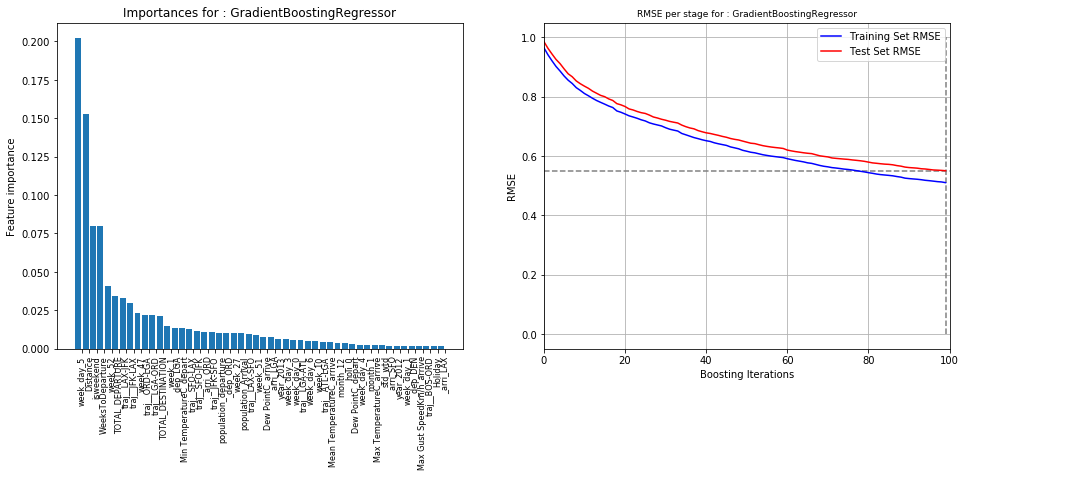

In [30]:
from sklearn.metrics import mean_squared_error

X_test_pipe = pipeline.fit_transform(X_test)
reg.fit(X, y_train)

name = " GradientBoostingRegressor"
fig, ax = plt.subplots(1,2,figsize=(16,6))
plot_coeff_importances(reg, X_test_pipe.columns, ax[0], title = name)
plot_stages(reg,X,y_train,X_test_pipe,y_test,ax[1], title = name)

In [31]:
feature_importance = reg.feature_importances_

In [32]:
feature_names = np.array(list(X.columns))

On affiche le diagramme en barre des importances sur l'ensemble de nos variables (25 meilleurs) :

In [33]:
idx = feature_importance.argsort()[::-1][:25]
importances_ord = feature_importance[idx]
feature_names_ord = np.array(feature_names)[idx]

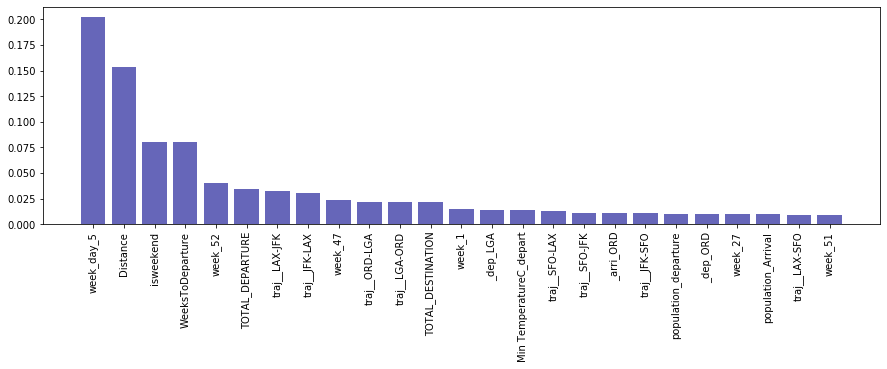

In [34]:
plt.figure(figsize=(15,4))

plt.bar(feature_names_ord, importances_ord, 
         color = 'darkblue', alpha= 0.6);
plt.xticks(rotation=90);

On applique un LGBM sur nos features selectionnées par le GBR pour connaître leur impact sur le modèle.

In [35]:
from lightgbm import LGBMRegressor

reg2 = LGBMRegressor(n_estimators=100, random_state=2)

scores = cross_val_score(reg2, X[feature_names_ord], 
                         y_train, cv=5,
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

reg2.fit(X[feature_names_ord],y_train)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.4598 +/- 0.0214


On peut regarder plus finement avec la librairie `shap` les importances en utilisant un Random Forests

In [36]:
shap.initjs()
explainer = shap.TreeExplainer(reg2)
shap_values = explainer.shap_values(X[feature_names_ord])
shap.force_plot(explainer.expected_value, shap_values[0,:], X[feature_names_ord].iloc[0,:])

L'explication ci-dessus montre les caractéristiques qui contribuent chacune à faire passer la sortie du modèle de la valeur de base (la sortie moyenne du modèle sur l'ensemble des données de train que nous avons passées) à la sortie du modèle. Les caractéristiques qui poussent la prédiction vers le haut sont indiquées en rouge, celles qui poussent la prédiction vers le bas sont en bleu (diagrammes de force).

### Features selection : SelectFromModel

In [37]:
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.linear_model import Lasso


def _selectfeatures(X):
    feature_names = np.array(list(X.columns))
    select = SelectFromModel(LGBMRegressor(), threshold="0.3*mean")
    select.fit_transform(X,y_train)
    selected_features = feature_names[select.get_support()]
    return X[selected_features]

lasso_select = FunctionTransformer(_selectfeatures)

In [38]:
feature_select = list(lasso_select.fit_transform(X).columns)
len(feature_select)

171

---
## Modèles
---

In [39]:
mydata = pipeline.fit_transform(X_train)
mydata_test = pipeline.fit_transform(X_test)

X_train_select = mydata[feature_select]
X_test_select = mydata_test[feature_select]

### Niveau 1 : RandomForest et ExtraTree

In [ ]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=100, random_state=2)

scores = cross_val_score(reg, X_train_select, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

boost = ExtraTreesRegressor(random_state=1)

scores = cross_val_score(boost, X_train_select, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

On peut regarder l'ExtraTree sur le jeu de données de test : 

In [ ]:
from sklearn.metrics import mean_squared_error

prediction = boost.fit(X_train_select, y_train).predict(X_test_select)

print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test,prediction))))

### Niveau 2 : Stacking des modèles de régressions

On peut utiliser une méthode d'ensemble pour stacker les modèles de régressions : 

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor

estimators = [('ridge', RidgeCV()),
               ('lasso', LassoCV(random_state=1)),
               ('gradboost', GradientBoostingRegressor()),
             ("random_forest",RandomForestRegressor())]

stack = StackingRegressor(estimators=estimators, 
                          final_estimator=ExtraTreesRegressor())

stack.fit(X_train_select,y_train);

In [ ]:
scores = cross_val_score(stack, X_train_select, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

Sur l'échantillon de Test : 

In [ ]:
pred = stack.predict(X_test_select)
print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test,pred))))

### Niveau 3 : XGBoost

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators= 500)

scores = cross_val_score(xgb, X_train_select, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

In [ ]:
prediction = xgb.fit(X_train_select, y_train).predict(X_test_select)

print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test,prediction))))

### Niveau 4 : LightGBM

In [40]:
from lightgbm import LGBMRegressor


lgbm = LGBMRegressor(n_estimators=200)


scores = cross_val_score(lgbm, X_train_select, 
                         y_train, cv=5,
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.3955 +/- 0.0260


In [41]:
prediction = lgbm.fit(X_train_select, y_train).predict(X_test_select)

print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test,prediction))))

RMSE: 0.3899


$R2$ : 

In [42]:
lgbm.score(X_test_select,y_test.reshape(-1,1)).round(3)

0.852

### Niveau 5 : Bagging des meilleurs modèles :  LGBM , XGBoost, ExtraTree et Random Forests

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor


esti = [("xgb",XGBRegressor(n_estimators=100))]


big = StackingRegressor(estimators=esti,
                 final_estimator=LGBMRegressor(n_estimators=100))

scores = cross_val_score(big, X_train_select, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

## Ramp : soumission sur la plateforme 

In [ ]:
!ramp-test --submission submit